In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import h, hbar, c, eps0, a0
from collections.abc import Sequence

from lightmatter import GaussianBeam, Lattice1d, BowtieLattice2d, LaserSetup

In [2]:
m_K40 = 39.96399848 * u.u # see Tiecke
alpha_S12 = (599.17 * 4*np.pi*eps0*a0**3 / h).to(u.Hz/(u.V/u.m)**2) # see Savronova

k = 2*np.pi/(1064*u.nm) 
Er = (hbar**2 * k**2 / (2*m_K40) / h).to(u.kHz)

Er

<Quantity 4.40985944 kHz>

In [3]:
w0 = 350 * u.um
lambda_ = 1064 * u.nm
P = 11 * u.W

bowtie = BowtieLattice2d(
    lattice_direction_vec1=(1,0,0),
    lattice_direction_vec2=(0,1,0),
    pol_Jones_vec=(0,1), # linear vertical
    lambda_=lambda_,
    w0=w0,
    P=P,
    z0=0,
)

lat1d_x = Lattice1d(
    lattice_direction_vec=(1,0,0),
    intersect_angle=0,
    pol_Jones_vec=(0,1), # linear horizontal
    lambda_=lambda_,
    w0=w0,
    P=P,
    z0=0,
)
lat1d_y = Lattice1d(
    lattice_direction_vec=(0,1,0),
    intersect_angle=0,
    pol_Jones_vec=(0,1), # linear horizontal
    lambda_=lambda_,
    w0=w0,
    P=P,
    z0=0,
)
lasers = [lat1d_x, lat1d_y]
lat2d = LaserSetup(lasers)

In [4]:
x, y, z = sp.symbols('x y z', real=True)
I_bowtie = bowtie.I_sym(x, y, z)
I_lat2d = lat2d.I_sym(x, y, z)

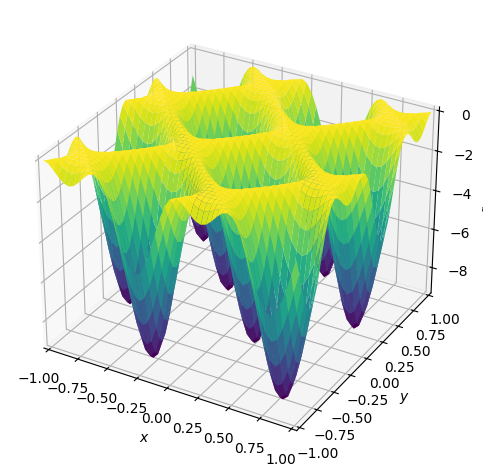

In [5]:
I_z0 = I_bowtie.subs(z, 0)
sp.plotting.plot3d(-I_z0, (x, -1, 1), (y, -1, 1))

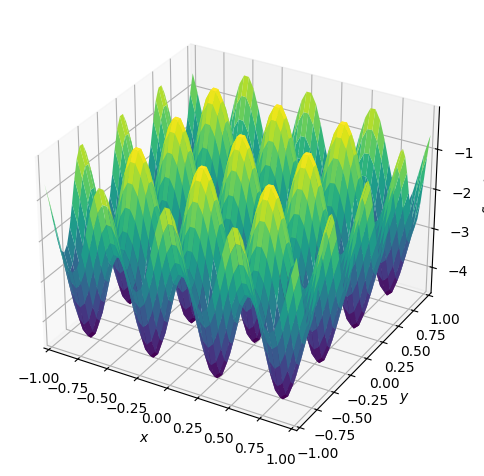

In [6]:
I_z0 = I_lat2d.subs(z, 0)
sp.plotting.plot3d(-I_z0, (x, -1, 1), (y, -1, 1))

In [7]:
d2I_bowtie_dx2 = sp.diff(I_bowtie, x, x)

In [5]:
n = 101

x = np.linspace(-1, 1, n) * u.um
y = np.linspace(-1, 1, n) * u.um
z = np.linspace(-100, 100, n) * u.um

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

I_bowtie = bowtie.I(X, Y, Z)
I_lat2d = lat2d.I(X, Y, Z)

/home/lelo/anaconda3/envs/lightmatter/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [8]:
V_bowtie = - (1/(2*eps0*c) * alpha_S12 * I_bowtie).to(u.kHz) / Er
V_lat2d = - (1/(2*eps0*c) * alpha_S12 * I_lat2d).to(u.kHz) / Er

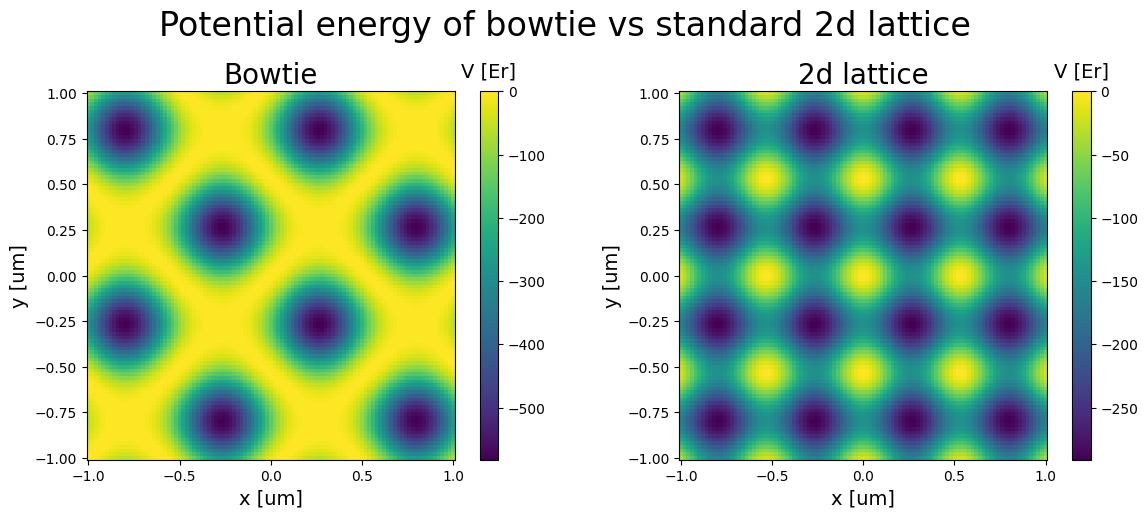

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Potential energy of bowtie vs standard 2d lattice', fontsize=24)

cax1 = axs[0].pcolormesh(x.value, y.value, V_bowtie[:,:,n//2].value)
axs[0].set_title('Bowtie', fontsize=20)
axs[0].set_xlabel('x [um]', fontsize=14)
axs[0].set_ylabel('y [um]', fontsize=14)
axs[0].set_aspect('equal')

cax2 = axs[1].pcolormesh(x.value, y.value, V_lat2d[:,:,n//2].value)
axs[1].set_title('2d lattice', fontsize=20)
axs[1].set_xlabel('x [um]', fontsize=14)
axs[1].set_ylabel('y [um]', fontsize=14)
axs[1].set_aspect('equal')

cbar1 = fig.colorbar(cax1)
cbar1.ax.set_title('V [Er]', fontsize=14, pad=10)
cbar2 = fig.colorbar(cax2)
cbar2.ax.set_title('V [Er]', fontsize=14, pad=10)


fig.tight_layout()

In [ ]:
def get_trap_frequencies(Vx, Vy, Vz, x_beam_params, y_beam_params, z_beam_params,):
    '''Calculate trap frequency of 3d lattice in z-direction.

        Args:
            Vx: Lattice depth in x-direction [Hz]
            Vy: Lattice depth in y-direction [Hz]
            w0_x: Beam waist radius in y- and z- direction of x-lattice beam [cm x cm]
            w0_y: Beam waist radius in x- and z- direction of y-lattice beam [cm x cm]
            z: Position of local trap frequency 

        Returns:
            w_trap: Laocal trap frequency [Hz]
    
    '''
    kx = 2*np.pi/(x_beam_params['lambda']*1e-9)
    ky = 2*np.pi/(y_beam_params['lambda']*1e-9)
    kz = 2*np.pi/(z_beam_params['lambda']*1e-9)

    w_trap_x = np.sqrt(2*Vx*h*(kx**2)/m) #Hz
    w_trap_y = np.sqrt(2*Vy*h*(ky**2)/m) #Hz
    w_trap_z = np.sqrt(2*Vz*h*(kz**2)/m) #Hz

    return w_trap_x, w_trap_y, w_trap_z



def get_lamb_dicke_parameter(w_trap, lattice_params):

    lambda_ = lattice_params['lambda']

    k = 2*np.pi/(lambda_*1e-9) #1/m
    w_rec = hbar*k**2/(2*m) #Hz

    eta = np.sqrt(w_rec/w_trap) 

    return eta


<h3>Lattice depth</h3>

In [4]:
x_beam_params = {'P': 10, #W
                 'lambda': 1064, #nm
                 'w0': [350e-4, 175e-4], #cm x cm
                 'theta': np.pi ,#rad
                 }

y_beam_params = {'P': 10, #W
                 'lambda': 1064, #nm
                 'w0': [350e-4, 175e-4], #cm x cm
                 'theta': np.pi ,#rad
                 }

z_beam_params = {'P': 0.5, #W
                 'lambda': 866, #nm
                 'w0': [50e-4, 50e-4], #cm x cm
                 'theta': 16.7/360 * 2*np.pi ,#rad
                 }

Erx, Vx = get_lattice_depth(x_beam_params)
Ery, Vy = get_lattice_depth(y_beam_params)
Erz, Vz = get_lattice_depth(z_beam_params)

print('x direction depth: ')
print('Er = ', Erx*1e-3, 'kHz')
print('Vlat/Er = ', Vx/Erx)
print('\n\n')
print('y direction depth: ')
print('Er = ', Ery*1e-3, 'kHz')
print('Vlat/Er = ', Vy/Ery)
print('\n\n')
print('z direction depth: ')
print('Er = ', Erz*1e-3, 'kHz')
print('Vlat/Er = ', Vz/Erz)

x direction depth: 
Er =  4.409859436263901 kHz
Vlat/Er =  264.030269003267



y direction depth: 
Er =  4.409859436263901 kHz
Vlat/Er =  264.030269003267



z direction depth: 
Er =  0.1403857769827029 kHz
Vlat/Er =  1465.7530268609225


<h3>Trapping frequencies</h3>

In [5]:
w_trap_x, w_trap_y, w_trap_z = get_trap_frequencies(Vx, Vy, Vz, x_beam_params, y_beam_params, z_beam_params,)

print('w_trap_x = 2pi x ', w_trap_x*1e-3 / (2*np.pi), 'kHz')
print('w_trap_y = 2pi x ', w_trap_y*1e-3 / (2*np.pi), 'kHz')
print('w_trap_z = 2pi x ', w_trap_z*1e-3 / (2*np.pi), 'kHz')

eta_x = get_lamb_dicke_parameter(w_trap_x, x_beam_params)
eta_y = get_lamb_dicke_parameter(w_trap_y, y_beam_params)
eta_z = get_lamb_dicke_parameter(w_trap_z, z_beam_params)

print('\n\n')
print('eta_x = ', eta_x)
print('eta_y = ', eta_y)
print('eta_z = ', eta_z)

w_trap_x = 2pi x  143.31168469380702 kHz
w_trap_y = 2pi x  143.31168469380702 kHz
w_trap_z = 2pi x  74.02153037219855 kHz



eta_x =  0.17541695707224672
eta_y =  0.17541695707224672
eta_z =  0.29988661345113604


In [6]:
P = 0.15 #W
w0 = [50e-4, 50e-4] #cm x cm
lambda_ = 866 #nm
theta = 16.7/360 * 2*np.pi #rad


a = lambda_*1e-9/(2*np.sin(theta/2)) #m
Er = h / (8*m*(a**2)) #Hz
V0 = 440*Er

I0 = 2*4*P/(np.pi*(w0[0]*w0[1])) #W/cm^2 

alpha = V0 / (1e4*(a0**3)/(c*hbar) * I0)

print('alpha = ', alpha)

alpha =  86.25373057384968
